파이토치(PyTorch)에는 데이터 작업을 위한 기본 요소 두가지인 torch.utils.data.DataLoader 와 torch.utils.data.Dataset 가 있습니다.

Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 순회 가능한 객체(iterable)로 감쌉니다.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch는 TorchText, TorchVision 및 TorchAudio 와 같이 도메인 특화 라이브러리를 데이터셋과 함께 제공하고 있습니다.

이 튜토리얼에서는 TorchVision 데이터셋을 사용하도록 하겠습니다.

torchvision.datasets 모듈은 CIFAR, COCO 등과 같은 다양한 실제 비전(vision) 데이터에 대한 Dataset(전체 목록은 여기)을 포함하고 있습니다.

이 튜토리얼에서는 FasionMNIST 데이터셋을 사용합니다.

모든 TorchVision Dataset 은 샘플과 정답을 각각 변경하기 위한 transform 과 target_transform 의 두 인자를 포함합니다.

In [2]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Dataset 을 DataLoader 의 인자로 전달합니다.

이는 데이터셋을 순회 가능한 객체(iterable)로 감싸고, 자동화된 배치(batch), 샘플링(sampling), 섞기(shuffle) 및 다중 프로세스로 데이터 불러오기(multiprocess data loading)를 지원합니다.

여기서는 배치 크기(batch size)를 64로 정의합니다.

즉, 데이터로더(dataloader) 객체의 각 요소는 64개의 특징(feature)과 정답(label)을 묶음(batch)으로 반환합니다.

In [9]:
batch_size = 64

# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=4)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## 모델 만들기
PyTorch에서 신경망 모델은 nn.Module 을 상속받는 클래스(class)를 생성하여 정의합니다.
 
__init__ 함수에서 신경망의 계층(layer)들을 정의하고 forward 함수에서 신경망에 데이터를 어떻게 전달할지 지정합니다. 

가능한 경우 GPU 또는 MPS로 신경망을 이동시켜 연산을 가속(accelerate)합니다.

In [10]:
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## 모델 매개변수 최적화하기
모델을 학습하려면 손실 함수(loss function) 와 옵티마이저(optimizer) 가 필요합니다.

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

각 학습 단계(training loop)에서 모델은 (배치(batch)로 제공되는) 학습 데이터셋에 대한 예측을 수행하고, 예측 오류를 역전파하여 모델의 매개변수를 조정합니다.

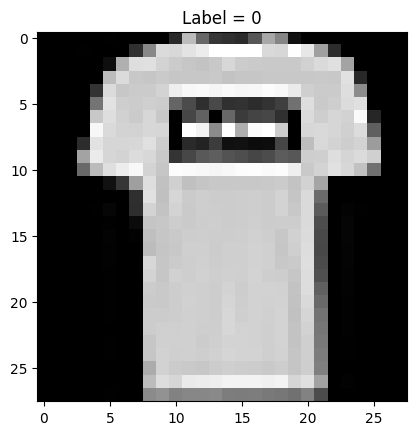

In [12]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0].view(28, 28), cmap='gray')
plt.title("Label = {}".format(training_data[1][1]))
plt.show()

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    indices = []
    loss_values = []
    
    # plt.figure(figsize=(10, 6))
    # plt.title('Training Loss over Epochs')
    # plt.xlabel('batch')
    # plt.ylabel('Loss')
    # plt.grid(True)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)
        
        loss_values.append(loss.item())
        indices.append(batch)

        # 역전파
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    # plt.plot(indices, loss_values, marker='o', linestyle='-', color='b', label='Training Loss')
    # plt.show()

모델이 학습하고 있는지를 확인하기 위해 테스트 데이터셋으로 모델의 성능을 확인합니다.

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100 * correct

학습 단계는 여러번의 반복 단계 (에폭(epochs)) 를 거쳐서 수행됩니다. 

각 에폭에서는 모델은 더 나은 예측을 하기 위해 매개변수를 학습합니다. 

각 에폭마다 모델의 정확도(accuracy)와 손실(loss)을 출력합니다.
 
에폭마다 정확도가 증가하고 손실이 감소하는 것을 보려고 합니다.

Epoch 10 [72.23, 73.18, 74.22, 74.92, 75.64999999999999, 76.34, 76.89, 77.44, 77.86999999999999]
-------------------------------
loss: 0.567237  [   64/60000]
loss: 0.674919  [ 6464/60000]
loss: 0.453259  [12864/60000]
loss: 0.694662  [19264/60000]
loss: 0.629093  [25664/60000]
loss: 0.599374  [32064/60000]
loss: 0.651077  [38464/60000]
loss: 0.672490  [44864/60000]
loss: 0.677312  [51264/60000]
loss: 0.624240  [57664/60000]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.618306 

time 72.16977405548096 sec


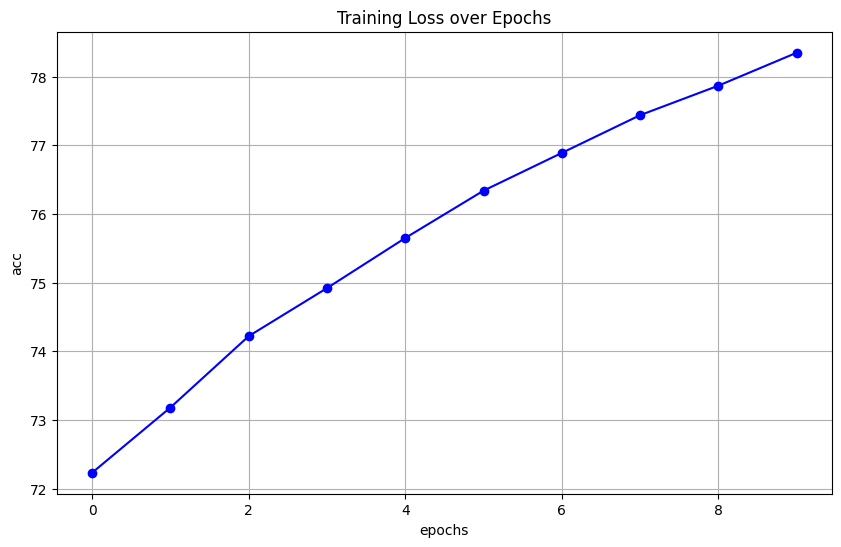

Done!


In [16]:
from IPython.display import clear_output
import time

epochs = 10
acc = 0
accs = []

start = time.time()
for t in range(epochs):
    clear_output()
    print(f"Epoch {t+1} {accs}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    acc = test(test_dataloader, model, loss_fn)
    accs.append(acc)
    if acc > 90:
        break
end = time.time()

print(f'time {end - start} sec')

plt.figure(figsize=(10, 6))
plt.title('Training Loss over Epochs')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.grid(True)
plt.plot(list(range(0, epochs)), accs, marker='o', linestyle='-', color='b', label='Training Loss')
plt.show()

print("Done!")

In [10]:
# 모델 저장하기
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [11]:
# 모델 불러오기
loaded_model = NeuralNetwork().to(device)
loaded_model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

loaded_model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = loaded_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
